In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("figure/1")
plt.ion()   

# Load Dataset

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(448),
        transforms.CenterCrop(448),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(448),
        transforms.CenterCrop(448),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'CUB_200_2011/CUB_200_2011'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

In [5]:
dataset_sizes

{'train': 5994, 'test': 5794}

# Visualize Dataset

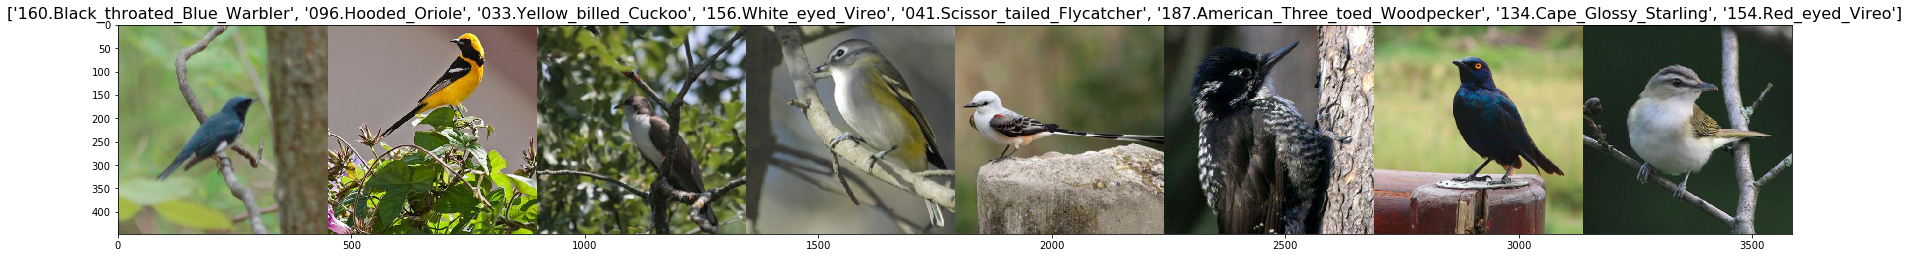

In [6]:
# Concatenate images horizontally
dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=4)
    for x in ['train', 'test']
    }
inputs, classes = next(iter(dataloders['train']))
out = np.zeros((3, 448, 1))
for pic in inputs:
    out = np.concatenate((out,pic), axis=2)

def visualize_pic(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=16)
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure(figsize=(30, 14))
visualize_pic(out, title=[class_names[x] for x in classes])

# Train Model

In [7]:
def train_model(model, criterion, optimizer, model_name, num_epochs=10, base_batch_size=8):
    assert (model_name == "vgg16" or model_name == "resnet34")
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
            
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= base_batch_size,
                                             shuffle=True, num_workers=4)
                  for x in ['train', 'test']}
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train(True) 
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0

            for data in dataloders[phase]:
                inputs, labels = data

                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()

                outputs = model(inputs)
                
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]
            writer.add_scalar(f'{model_name}/Loss/{phase}', epoch_loss, epoch)
            writer.add_scalar(f'{model_name}/Accuracy/{phase}', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                state = {'model':model.state_dict(),'optim':optimizer.state_dict()}
                torch.save(state,'CUB_200_2011/CUB_200_2011/%s_best_epoch_%d_acc_%g.pth' % (model_name, epoch, best_acc))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Training process for Resnet34

In [14]:
model = "resnet34"
model_ft = models.resnet34(pretrained=True) 
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 200)      
 
if use_gpu:                                 
    model_ft = model_ft.cuda()       
criterion = nn.CrossEntropyLoss()           

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=50, base_batch_size=8)

Epoch 0/49
----------
train Loss: 0.6656 Acc: 0.0105
test Loss: 0.6459 Acc: 0.0276

Epoch 1/49
----------
train Loss: 0.6359 Acc: 0.0309
test Loss: 0.6183 Acc: 0.0602

Epoch 2/49
----------
train Loss: 0.6077 Acc: 0.0797
test Loss: 0.5868 Acc: 0.1139

Epoch 3/49
----------
train Loss: 0.5788 Acc: 0.1411
test Loss: 0.5529 Acc: 0.1691

Epoch 4/49
----------
train Loss: 0.5491 Acc: 0.1935
test Loss: 0.5168 Acc: 0.2330

Epoch 5/49
----------
train Loss: 0.5213 Acc: 0.2442
test Loss: 0.4857 Acc: 0.2824

Epoch 6/49
----------
train Loss: 0.4941 Acc: 0.2996
test Loss: 0.4563 Acc: 0.3227

Epoch 7/49
----------
train Loss: 0.4682 Acc: 0.3445
test Loss: 0.4279 Acc: 0.3630

Epoch 8/49
----------
train Loss: 0.4449 Acc: 0.3832
test Loss: 0.3972 Acc: 0.4078

Epoch 9/49
----------
train Loss: 0.4225 Acc: 0.4214
test Loss: 0.3757 Acc: 0.4470

Epoch 10/49
----------
train Loss: 0.4012 Acc: 0.4636
test Loss: 0.3559 Acc: 0.4843

Epoch 11/49
----------
train Loss: 0.3808 Acc: 0.5050
test Loss: 0.3353 Acc

# Traning process for Vgg16:

In [11]:
model = "vgg16"
model_ft = models.vgg16(pretrained=True) 
 
if use_gpu:                                 
    model_ft = model_ft.cuda()       

criterion = nn.CrossEntropyLoss()           

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /tmp/xdg-cache/torch/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 90.3MB/s] 


In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, model, num_epochs=50, base_batch_size=8)

Epoch 0/49
----------
train Loss: 0.7480 Acc: 0.0098
test Loss: 0.6671 Acc: 0.0252

Epoch 1/49
----------
train Loss: 0.6336 Acc: 0.0375
test Loss: 0.5653 Acc: 0.0654

Epoch 2/49
----------
train Loss: 0.5418 Acc: 0.0888
test Loss: 0.4782 Acc: 0.1529

Epoch 3/49
----------
train Loss: 0.4542 Acc: 0.1672
test Loss: 0.3984 Acc: 0.2458

Epoch 4/49
----------
train Loss: 0.3716 Acc: 0.2768
test Loss: 0.3413 Acc: 0.3241

Epoch 5/49
----------
train Loss: 0.3032 Acc: 0.3727
test Loss: 0.2963 Acc: 0.3937

Epoch 6/49
----------
train Loss: 0.2484 Acc: 0.4760
test Loss: 0.2600 Acc: 0.4555

Epoch 7/49
----------
train Loss: 0.2011 Acc: 0.5589
test Loss: 0.2508 Acc: 0.4824

Epoch 8/49
----------
train Loss: 0.1639 Acc: 0.6330
test Loss: 0.2343 Acc: 0.5093

Epoch 9/49
----------
train Loss: 0.1353 Acc: 0.6860
test Loss: 0.2126 Acc: 0.5620

Epoch 10/49
----------
train Loss: 0.1135 Acc: 0.7344
test Loss: 0.2063 Acc: 0.5739

Epoch 11/49
----------
train Loss: 0.0913 Acc: 0.7818
test Loss: 0.2024 Acc

In [24]:
model_ft = models.vgg16(pretrained=False) 
record = torch.load(os.path.join('CUB_200_2011/CUB_200_2011',
                                              'vgg16_best_epoch_39_acc_0.662409.pth'),
                                              map_location=lambda storage, loc: storage)
model_ft.load_state_dict(record['model'])


<All keys matched successfully>

# Visualize predictions

The correct class is 140.Summer_Tanager


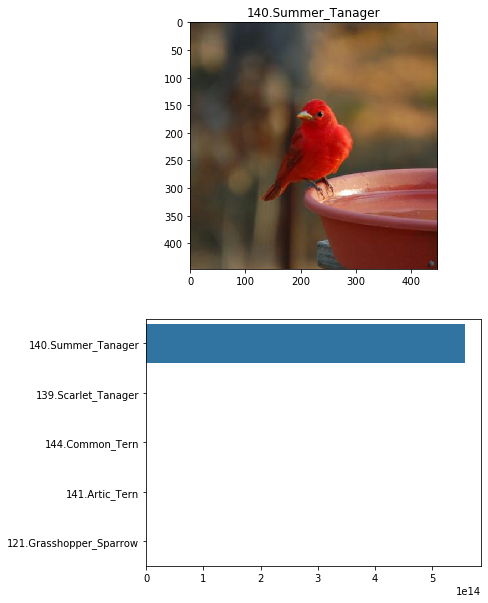

In [33]:
if use_gpu:                                 
    model_ft = model_ft.cuda()  
def visualize_pic(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    if title:
        plt.title(title)
    image = image.numpy().transpose((1, 2, 0))
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


dataloders = {
    x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1, shuffle=True, num_workers=4)
    for x in ['train', 'test']
    }
image_tensor, label = next(iter(dataloders['test']))
print("The correct class is", class_names[label[0]])

def visualize_prediction(image_tensor, label, model, top_num=5):
    model_input = image_tensor.unsqueeze(0)
    
    # Probs
    probs = torch.exp(model.forward(Variable(model_input.cuda())))
    
    # Top probs
    top_probs, top_labs = probs.topk(top_num)
    top_probs, top_labs =top_probs.data, top_labs.data
    top_probs = top_probs.cpu().numpy().tolist()[0] 
    top_labs = top_labs.cpu().numpy().tolist()[0]
    
    top_birds = [class_names[lab] for lab in top_labs]

    plt.figure(figsize = (6,10))
    ax = plt.subplot(2,1,1)
    
    # Plot flower
    title_ = label
    visualize_pic(image_tensor, ax, title = title_);

    # Plot bar chart
    plt.subplot(2,1,2)
    sns.barplot(x=top_probs, y=top_birds, color=sns.color_palette()[0]);
    plt.show()

visualize_prediction(image_tensor[0], class_names[label[0]], model_ft)